[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sascha-senko/TensorflowCourse/blob/main/ANNwTFHW7.ipynb)

## Imports

In [17]:
import matplotlib.pyplot as plt
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Conv2DTranspose, Reshape
from tensorflow import debugging as debug
import tensorflow_probability as tfp

## Load dataset

In [18]:
(x_train, _), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = tf.data.Dataset.from_tensor_slices(x_train)
# take only first 1000 examples
x_test = tf.data.Dataset.from_tensor_slices(x_test).take(1000)

# take only first 1000 examples
y_test = y_test[:1000]

## Inspect data set

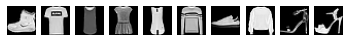

In [19]:
fig, ax = plt.subplots(1,10)

for i, img in enumerate(x_train):
    if i == 10:
        break
    ax[i].imshow(img, cmap='gray')
    ax[i].axis("off")

## Define some constants

In [20]:
# arbitrarily set. Feel free to change these
SHUFFLE_SIZE = x_test.cardinality()
PREFETCH_SIZE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64

## Prepare data

In [21]:
def process_inp(input):
    """ rescale and add channel dimension """
    # normalize between zero and one
    input = input / 255
    # add extra dimension for channel
    input = tf.expand_dims(input, -1)
    return input    



def data_pipeline(data, training):
    """ helper function for data pipeline - does all the things we need """
    
    data = data.map(process_inp)

    if training:
        data = data.shuffle(buffer_size=SHUFFLE_SIZE)

    data = data.batch(BATCH_SIZE)
    data = data.prefetch(PREFETCH_SIZE)
    return data

x_train = data_pipeline(x_train, True)
x_test = data_pipeline(x_test, False)

## Encoder

In [22]:
class Encoder(Model):
    def __init__(self, filter_size, kernel_size, embedding_size):
        super(Encoder, self).__init__()
        self.conv_layer = Conv2D(filters=filter_size, kernel_size=kernel_size, strides=(1,1))
        self.pool_layer = MaxPooling2D(pool_size=(2,2))
        self.flatten = Flatten()
        self.output_layer = Dense(units=embedding_size, activation=tf.nn.sigmoid)


    def call(self, x):
      x = self.conv_layer(x)
      x = self.pool_layer(x)
      x = self.flatten(x)
      x = self.output_layer(x)
      return x

### Check Encoder

In [23]:
test_inp = next(iter(x_train))
encoder = Encoder(filter_size=16, kernel_size=[3,3], embedding_size=10) 
out = encoder(test_inp) 
# Assert that shape of out is BATCH_SIZE, 10
debug.assert_equal(out.shape, tf.zeros((BATCH_SIZE, 10)).shape)

## Decoder

In [24]:
class Decoder(Model):
    def __init__(self, dense_units, filter_size, kernel_size):
        super(Decoder, self).__init__()
        self.dense_layer = Dense(units=dense_units) # how many ? 
        self.reshape = Reshape((28, 28, 1))
        self.conv_t = Conv2DTranspose(filters=filter_size, kernel_size=kernel_size)
        self.output_layer = Conv2D(filters=1, kernel_size=kernel_size, activation=tf.nn.sigmoid)
        
    def call(self, x):
      x = self.dense_layer(x)
      x = self.reshape(x)
      x = self.conv_t(x)
      x = self.output_layer(x)
      return x

### Check Decoder

In [25]:
test_inp = tf.random.uniform((BATCH_SIZE, 10))
decoder = Decoder(dense_units=28*28, filter_size = 16, kernel_size = [3,3])
out = decoder(test_inp)
# Assert that shape of out is BATCH_SIZE, 28, 28, 1
check_tensor = tf.zeros((BATCH_SIZE, 28, 28, 1))
# Check shape
debug.assert_equal(out.shape, check_tensor.shape)
# Check values between 0 and 1
debug.assert_greater_equal(out, check_tensor)
debug.assert_less_equal(out, check_tensor + 1)

## Autoencoder

In [26]:
class Autoencoder(Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(filter_size=16, kernel_size=[3,3], embedding_size=10)
        self.decoder = Decoder(dense_units=28*28, filter_size = 16, kernel_size = [3,3])

    def encode(self, x):
        return self.encoder(x)    

    def decode(self, x):
        return self.decoder(x)    

    def call(self, x):    
        x = self.encode(x)
        x = self.decode(x)

        return x

## VAE

In [40]:
class VAE(Autoencoder):
    def __init__(self):

        super(VAE, self).__init__()
        # prior p_{\theta}(z) modeled with an isotropic Gaussian 
        prior = tfp.distributions.Independent(tfp.distributions.Normal(loc=tf.zeros(10), scale=1),
                        reinterpreted_batch_ndims=1)
        
        # replace encoder's dense layer with one with a different output dim
        # needed to feed into self.prob_encoder (see below)
        dense_encoder_dim = tfp.layers.MultivariateNormalTriL.params_size(10)
        self.encoder.output_layer = Dense(dense_encoder_dim)

        # KL term. Prior gets memorized through this
        kl_reg = tfp.layers.KLDivergenceRegularizer(prior, weight=1.0)
        # q_{\theta}(x|z)
        self.prob_encoder = tfp.layers.MultivariateNormalTriL(10, activity_regularizer=kl_reg)
        # add flatten + dense layer for feeding into self.prob_decoder (see below)
        self.decoder_flatten = Flatten()
        dense_decoder_dim = tfp.layers.IndependentNormal.params_size((28, 28, 1))
        self.decoder_dense = Dense(dense_decoder_dim) 
        # p_{\theta}(z|x). We picked a normal distribution, since 
        # it's a good way to model real values
        self.prob_decoder = tfp.layers.IndependentNormal((28, 28, 1))

    def encode(self, x):
        x = self.encoder(x)
        # this returns a distribution object. However, if we call a
        # tensorflow function that expects a tensor, it implicitly samples
        # from itself
        x = self.prob_encoder(x)
        return x

    def decode(self, x):
        x = self.decoder(x)
        x = self.decoder_flatten(x)
        x = self.decoder_dense(x)
        # see comment above line "x = self.prob_encoder(x)""
        x = self.prob_decoder(x)
        return x
        
    def call(self, x):    
        x = self.encode(x)
        x = self.decode(x)

        return x    
        
# VAE loss function. Needs to be called (immediately) after using model's call
# on target, since the corresponding KL loss gets calculated in call
def vae_loss(target, prediction, kl_loss):
    loss = tf.reduce_mean(kl_loss)
    loss -= tf.reduce_mean(prediction.log_prob(target)) 
    return loss

## Helper functions

In [41]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = None
    if isinstance(model, VAE):
        loss = loss_function(target, prediction, model.losses)
    else:    
        loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function):
  # test over complete test data

  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = None
    if isinstance(model, VAE):
        sample_test_loss = loss_function(target, prediction, model.losses)
    else:
        sample_test_loss = loss_function(target, prediction)
    test_loss_aggregator.append(sample_test_loss.numpy())

  test_loss = np.mean(test_loss_aggregator)

  return test_loss
  

def plot_stats(train_stat, test_stat, stat_name):
    
    plt.figure()
    line1, = plt.plot(train_stat)
    line2, = plt.plot(test_stat)
    plt.xlabel("Epochs")
    plt.ylabel(stat_name)
    plt.legend((line1, line2), ("training", "test"))
    plt.show()

## Prepare for training

In [42]:
NUM_EPOCHS = 10
LEARNING_RATE = 0.001   
loss = None
OPTIMIZER = tf.keras.optimizers.Adam(LEARNING_RATE)
TRAIN_STAT_DIM = (int(x_train.cardinality()))

## Train

Model: VAE
Epoch: 1

tf.Tensor(-140.92577, shape=(), dtype=float32)


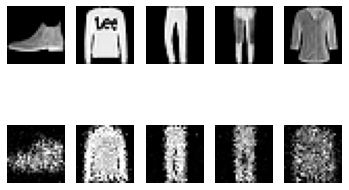

Epoch: 2

tf.Tensor(-646.96356, shape=(), dtype=float32)


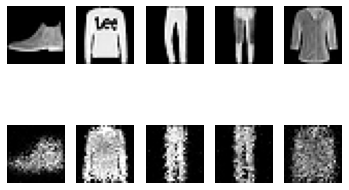

Epoch: 3

tf.Tensor(-938.14087, shape=(), dtype=float32)


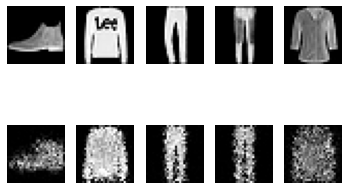

Epoch: 4

tf.Tensor(-1068.9514, shape=(), dtype=float32)


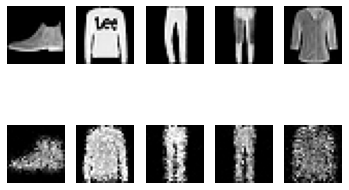

Epoch: 5

tf.Tensor(-1155.5415, shape=(), dtype=float32)


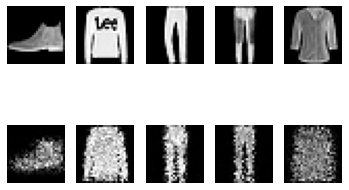

Epoch: 6

tf.Tensor(-843.3014, shape=(), dtype=float32)


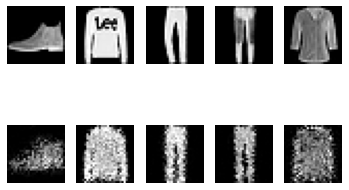

Epoch: 7

tf.Tensor(-1312.2345, shape=(), dtype=float32)


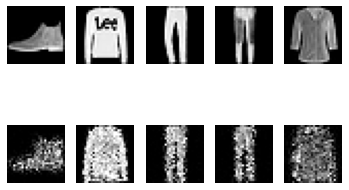

Epoch: 8

tf.Tensor(-1311.3914, shape=(), dtype=float32)


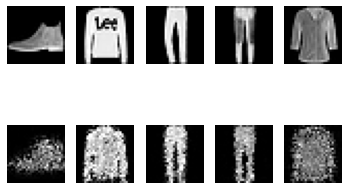

Epoch: 9

tf.Tensor(-1223.4756, shape=(), dtype=float32)


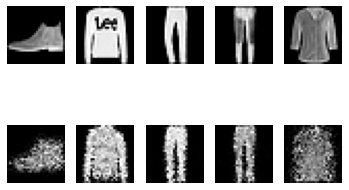

Epoch: 10

tf.Tensor(-1441.3115, shape=(), dtype=float32)


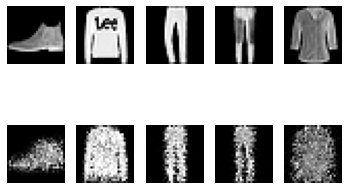

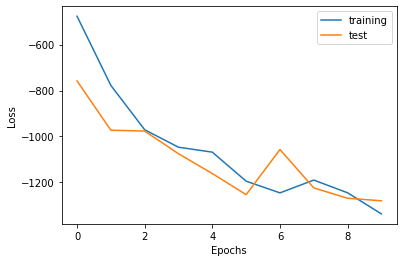

In [43]:
# remove all active models for memory purposes
tf.keras.backend.clear_session()

models = {'Autoencoder': Autoencoder(), 'VAE': VAE()}

losses = {'Autoencoder': tf.keras.losses.MeanSquaredError(),
          'VAE': vae_loss}

for model_name in models:

    print('Model: ' + model_name)

    model = models[model_name]
    loss = losses[model_name]

    # Initialize lists for later visualization.
    train_losses = []
    test_losses = []

    for epoch in range(NUM_EPOCHS):
        print('Epoch: ' + str(epoch+1) + "\n")

        # shuffle train data. No need to shuffle test data. Since SHUFFLE_SIZE 
        # is bigger than number of batches we will shuffle the whole set
        x_train = x_train.shuffle(buffer_size=SHUFFLE_SIZE)

        train_loss_stat = np.empty(TRAIN_STAT_DIM)

        for i, input in enumerate(x_train):
            train_loss = train_step(model, input, input, loss, OPTIMIZER)
            train_loss_stat[i] = train_loss
        train_losses.append(np.mean(train_loss_stat))

        # testing
        test_loss = test(model, zip(x_test, x_test), loss)
        test_losses.append(test_loss)

        # plot some example images from test set with counter examples
        test_batch = next(iter(x_test))

        # squeeze is needed to change shape from (28, 28, 1) to (28, 28)
        recon_batch = tf.squeeze(model(test_batch))

        if model_name == 'VAE':
            # clip, since normal distribution can also return values outside
            # of 0 and 1
            recon_batch = tf.clip_by_value(recon_batch, 0, 1)

        test_batch = tf.squeeze(test_batch)

        fig, ax = plt.subplots(2,5)

        for i in range (5):  
            ax[0, i].imshow(test_batch[i], cmap='gray')
            ax[1, i].imshow(recon_batch[i], cmap='gray')
            ax[0, i].axis("off")
            ax[1, i].axis("off")    

        plt.show()       

    # plot loss

    plot_stats(train_losses, test_losses, "Loss")

## Analysis: TSNE and Interpolation

In [ ]:
from sklearn.manifold import TSNE

for model_name, model in models.items():

    print('Model: ' + model_name)

    embeddings = []

    # Get the embedding of the first 1000 images
    for test_batch in x_test:
        
        recon_batch = model.encode(test_batch)

        if model_name == 'VAE':
            # sample, since recon_batch is still a distribution object
            recon_batch = recon_batch.sample()

        embeddings.extend(recon_batch.numpy())      


    # apply TSNE
    reduced_embeds = TSNE().fit_transform(embeddings)

    # plot TSNE

    # Create scatterplot with coloring according to classes
    plt.scatter(reduced_embeds[:,0], reduced_embeds[:,1], c=y_test)
    plt.show()

    # plot intepolation

    fig, ax = plt.subplots(1,5)

    n = len(embeddings)

    # pick two random embeddings
    embed1 = embeddings[np.random.choice(n)]
    embed2 = embeddings[np.random.choice(n)]
    diff = embed2 - embed1

    # interpolate linearly in 5 steps. First image is from embed1, last image is from embed2
    for i, perc in enumerate((0, 0.25, 0.5, 0.75, 1)):
        embed = embed1 + diff * perc 
        # add batch dimension to feed into decoder
        embed = np.expand_dims(embed, axis=0)
        out = model.decode(embed)

        if model_name == 'VAE':
            out = tf.clip_by_value(out, 0, 1)

        # remove batch and channel dimension
        out = np.reshape(out, (28, 28))
        ax[i].imshow(out, cmap='gray')
        ax[i].axis("off")    

    plt.show()

# TODO: Is this what I expected?
# TODO: How is it related to courseware?